# Защита персональных данных клиентов

В ходе исследования следует защитить данные клиентов страховой компании «Хоть потоп». То есть, разработать такой метод преобразования данных, чтобы по ним было сложно восстановить персональную информацию. Корректность его работы необходимо обосновать.

Нужно защитить данные, чтобы при преобразовании качество моделей машинного обучения не ухудшилось. Подбирать наилучшую модель не требуется.

**Цель исследования**

1. Проанализировать и обработать предложенные данные
2. Провести теоретические изыскания в части влиянии умножения матрицы признаков на произвольную обратимую матрицу подходящего размера
3. На основе этих изысканий разработать метод предобразования данных и теоретически его обосновать
4. Продемонстрировать корректность выводов П2 и алгоритма преобразования из П3 на примере обучения модели линейной регрессии из библиотеки scikit-learn, удостовериться, что значение кооэффициента детерминации не ухудшидся по сравнению с исходной матрицей признаков

**Ход Исследования**

Данные клиентах в файле "insurance.csv". О качестве данных ничего не известно. Поэтому перед тем, как приступать к целям исследования, понадобится обзор данных

Я проверю данные на ошибки и оценю их влияние на исследование. Затем, на этапе предобработки я поищу возможность исправить все ошибки данных, которые не приведут к искажению конечного результата.

Анализ в свою очередь пройдет в два этапа:

1. Теоретичесикй
    - Исследование влияния умножения матрицы признаков на произвольную обратимую матрицу подходящего размера
    - Описание и обоснование алгоритма преобразования матрицы признаков
    
2. Практический
    - На модели линейной регрессии из библиотеки scikit-learn проверим верность теоретической части. В числе прочего, проверим изменится ли значение коэффициента детерминации при предложенных преобразованиях
    
**Описание данных**

* **Признаки:**
    + **Пол** -- пол Клиента
    + **Возраст** -- возраст Клиента
    + **Зарплата** -- зарплата Клиента
    + **Члены семьи** -- количество членов семьи Клиента
* **Целевой признак**
    + **Страховые выплаты** -- количество страховых выплат Клиенту за последние 5 лет
    
_______________________

Для начала импортируем библиотеки и зафиксируем глобальные константы:

In [1]:
import pandas as pd
import numpy as np
import warnings 

import seaborn as sns 
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression 

In [2]:
warnings.filterwarnings('ignore') # отключаем предупреждения

## Шаг 1 Подготовка данных

### 1.1 Открыть и изучить данные

In [3]:
try:
    d_ins = pd.read_csv('datasets/insurance.csv', sep=',') # загружаем с локального хранилища
    
    print('*' * 50, 'Исходные данные клиентов', sep='\n')
    display(d_ins.head(5))
    print()
    d_ins.info()

except:
    d_ins = pd.read_csv('https://code.s3.yandex.net/datasets/insurance.csv', sep=',') # загружаем из хранилища Яндекс
    
    print('Файл загружен из хранилища Яндекс')
    print('*' * 50, 'Исходные данные клиентов', sep='\n')
    display(d_ins.head(5))
    print()
    d_ins.info()

**************************************************
Исходные данные клиентов


,Пол,Возраст,Зарплата,Члены семьи,Страховые выплаты
0,1,41.0,49600.0,1,0
1,0,46.0,38000.0,1,1
2,0,29.0,21000.0,0,0
3,0,21.0,41700.0,2,0
4,1,28.0,26100.0,0,0



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Пол                5000 non-null   int64  
 1   Возраст            5000 non-null   float64
 2   Зарплата           5000 non-null   float64
 3   Члены семьи        5000 non-null   int64  
 4   Страховые выплаты  5000 non-null   int64  
dtypes: float64(2), int64(3)
memory usage: 195.4 KB


**Посмотрим на распределение значений:**

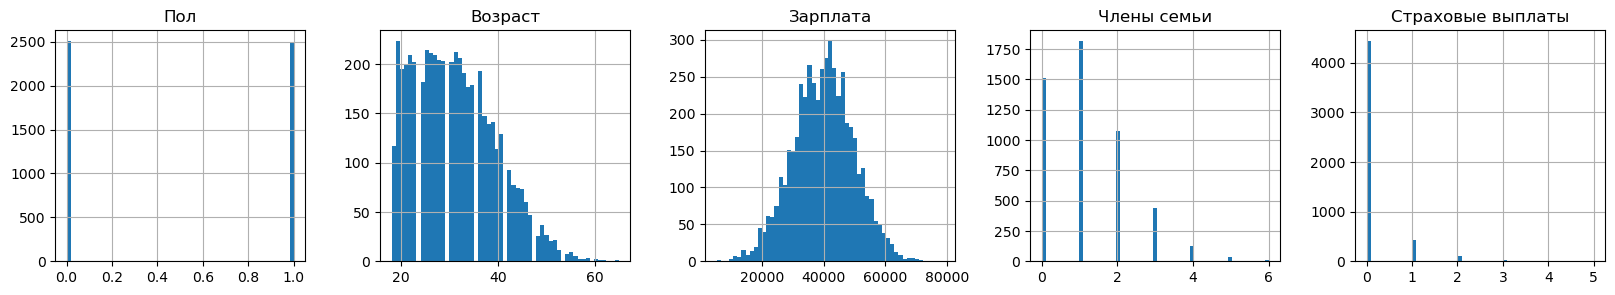

In [4]:
d_ins.hist(bins=55, figsize=(20, 3), layout=(1, 5));

По распределению похоже на правду. 

**Посмотрим на зависимости признаков:**

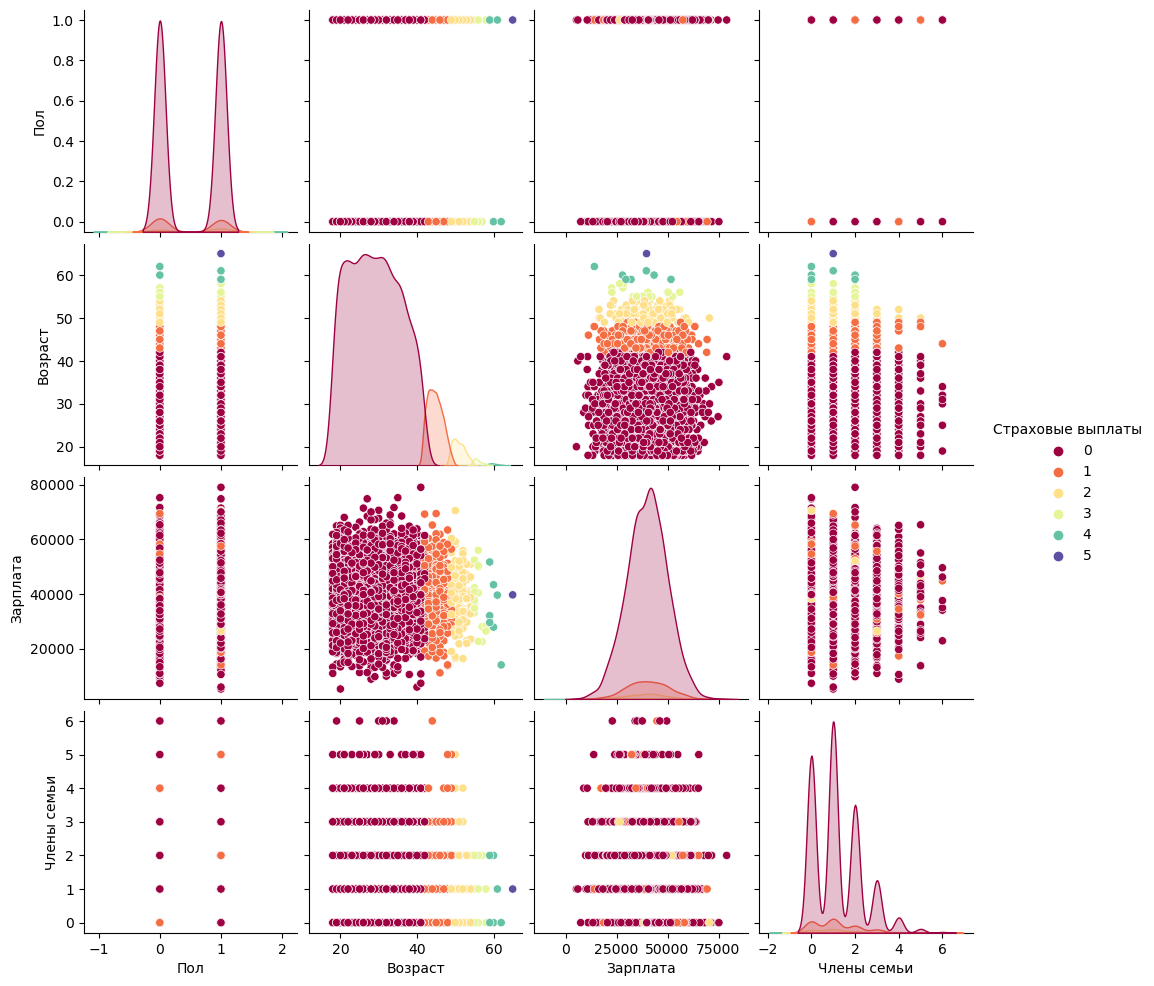

In [5]:
sns.pairplot(d_ins, palette="Spectral", hue="Страховые выплаты")

Похоже на то, что внутри признаков сильных и средних зависимостей нет, но целевой признак линейно зависит от некоторых признаков.

**Посмотрим на float признаки, чтоб явно понимать, можно ли их привести к int:**

In [6]:
print('Количество строк с нецелым значением по полю', d_ins.loc[d_ins['Возраст'] % 1 > 0, ['Возраст']].count())

print('Количество строк с нецелым значением по полю', d_ins.loc[d_ins['Зарплата'] % 1 > 0, ['Зарплата']].count())

Количество строк с нецелым значением по полю Возраст    0
dtype: int64
Количество строк с нецелым значением по полю Зарплата    40
dtype: int64


In [7]:
abs(d_ins.loc[d_ins['Зарплата'] % 1 > 0, ['Зарплата']] - (d_ins.loc[d_ins['Зарплата'] % 1 > 0, ['Зарплата']] / 1)).sum()

Зарплата    0.0
dtype: float64

Все в порядке, сумма значений после запятой ничтожно мала.

**Проверим данные на полные дубликаты:**

In [8]:
d_ins.loc[d_ins.duplicated() == 1, :]

,Пол,Возраст,Зарплата,Члены семьи,Страховые выплаты
281,1,39.0,48100.0,1,0
488,1,24.0,32900.0,1,0
513,0,31.0,37400.0,2,0
718,1,22.0,32600.0,1,0
785,0,20.0,35800.0,0,0
...,...,...,...,...,...
4793,1,24.0,37800.0,0,0
4902,1,35.0,38700.0,1,0
4935,1,19.0,32700.0,0,0
4945,1,21.0,45800.0,0,0


**Итого, данные следует обработать:**

1. Переименовать колонки
2. Удалить дубликаты
3. Перевести все признаки в int

### 1.2 Предобработка

#### 1.2.1 Переименовываем колонки

In [9]:
d_ins.columns = ['gender', 'age', 'salary', 'f_members', 'insur_pay']
d_ins.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   gender     5000 non-null   int64  
 1   age        5000 non-null   float64
 2   salary     5000 non-null   float64
 3   f_members  5000 non-null   int64  
 4   insur_pay  5000 non-null   int64  
dtypes: float64(2), int64(3)
memory usage: 195.4 KB


#### 1.2.2 Удаляем дубликаты

В предыдущем подразделе мы нашли 153 полных дубля. Есть, конечно, вероятность, что это разные люди с идентичными данными -- мы об этом не узнаем, айдишников-то нет.
Так или иначе, их немного, удалим на всякий:

In [10]:
d_ins = d_ins.drop_duplicates()
d_ins.shape

(4847, 5)

#### 1.2.3 Приводим типы

Сначала явно округлим, потом переведем в int.

In [11]:
d_ins = d_ins.round()

In [12]:
d_ins['age'] = d_ins['age'].astype('int')
d_ins['salary'] = d_ins['salary'].astype('int')

d_ins.dtypes  

gender       int64
age          int32
salary       int32
f_members    int64
insur_pay    int64
dtype: object

**Предобработка звершена, в рамках неё мы:**

1. Переименовали колонки
2. Избавились от дубликатов
3. Перевели всё в int

## Шаг 2 Исследование влияния умножения матрицы признаков на произвольную обратимую матрицу подходящего размера

**Поставленный вопрос:** "Признаки умножают на обратимую матрицу. Изменится ли качество линейной регрессии?"

Далее будет вывод формулы обучения $\overrightarrow w = (X^TX)^{-1}X^T\overrightarrow y$ (Лемма 1). Оставил для себя и потомков, так как в курсе этого вывода нет, в найденных мной статьях он как-то немёками подан, поэтому принял решение зафиксировать тут достаточно полный вариант.

$Пусть\ даны\ результаты\ m\ измерений\ в\ рамках\ каждого\ из\ которых\ были\ зафиксированы\ значения\ n\ признаков.$
$Вектор\ предсказаний\ a\ для\ модели\ линейной\ регрессии\ будет:\$


$$\overrightarrow p = X^{'}\overrightarrow w^{'} + \overrightarrow w_0^{'}\ где$$

- $X^{'}\ -\ матрица\ признаков\ размера\ (m\times n),\ где a_{i,j}\ -\ значение\ j-го\ признака\ i-го\ измерения$
- $\overrightarrow w^{'}\ -\ вектор\ весов\ линейной\ регрессии\ размера\ (n\times 1),$
- $\overrightarrow w_0^{'}\ -\ вектор\ величины\ сдвига\ предсказания.\ Представляет\ из\ себя\ вектор\ (m\times 1),\ где\ w_{0_i}^{'}=w_0,\forall i\in [1, m].\ Значение\ w_0\ в\ свою\ очередь, очевидно,\ - скалярное.$

$То\ есть,$
$$
\begin{pmatrix}
  p_{1}\\
  p_{2}\\
  \vdots  \\
  p_{m} 
 \end{pmatrix}
 =
 \begin{pmatrix}
  x_{1,1} & x_{1,2} & \cdots & x_{1,n} \\
  x_{2,1} & x_{2,2} & \cdots & x_{2,n} \\
  \vdots  & \vdots  & \ddots & \vdots  \\
  x_{m,1} & x_{m,2} & \cdots & x_{m,n} 
 \end{pmatrix}
 \times
 \begin{pmatrix}
  w_{1}\\
  w_{2}\\
  \vdots  \\
  w_{n} 
 \end{pmatrix}
 +
 \begin{pmatrix}
  w_0\\
  w_0\\
  \vdots  \\
  w_0 
 \end{pmatrix}
 .
 $$
 
 $Перепишем\ выражение\ в\ более\ компактном\ виде:$
 $$
\begin{pmatrix}
  p_{1}\\
  p_{2}\\
  \vdots  \\
  p_{m}
 \end{pmatrix}
 =
 \begin{pmatrix}
  1 & x_{1,1} & x_{1,2} & \cdots & x_{1,n} \\
  1 & x_{2,1} & x_{2,2} & \cdots & x_{2,n} \\
  \vdots  & \vdots  & \vdots  & \ddots & \vdots  \\
  1 & x_{m,1} & x_{m,2} & \cdots & x_{m,n} 
 \end{pmatrix}
 \times
 \begin{pmatrix}
  w_0\\
  w_{1}\\
  w_{2}\\
  \vdots  \\
  w_{n} 
 \end{pmatrix}
 ;
 $$
 
 $В\ обоих\ случаях\ вектор\ предсказаний\ будет\ равен:$
 
 $$\begin{pmatrix}
  p_{1}\\
  p_{2}\\
  \vdots  \\
  p_{m}
 \end{pmatrix}
 =
 \begin{pmatrix}
  w_0 + x_{1,1}*w_{1}+x_{1,2}*w_{2}+\cdots+x_{1,n}*w_{n}\\
  w_0 + x_{2,1}*w_{2}+x_{2,2}*w_{2}+\cdots+x_{2,n}*w_{n}\\
  \vdots  \\
  w_0 + x_{m,1}*w_{2}+x_{m,2}*w_{2}+\cdots+x_{m,n}*w_{n}
 \end{pmatrix}.
 $$
 
 $Обозначим\ расширенную\ матрицу\ как\ X,\ а\ вектор,\ который\ объединяет\ веса\ и\ величину\ сдвига,\ как\ \overrightarrow w.$
 
 $То\ есть,$
 
 $$
 X = 
 \begin{pmatrix}
  1 & x_{1,1} & x_{1,2} & \cdots & x_{1,n} \\
  1 & x_{2,1} & x_{2,2} & \cdots & x_{2,n} \\
  \vdots  & \vdots  & \vdots  & \ddots & \vdots  \\
  1 & x_{m,1} & x_{m,2} & \cdots & x_{m,n} 
 \end{pmatrix},
 $$
 
 
 $$
 \overrightarrow w=
  \begin{pmatrix}
  w_0\\
  w_{1}\\
  w_{2}\\
  \vdots  \\
  w_{n} 
 \end{pmatrix}.
 $$
 
 $Получаем\ функцию:$
 
 
 $$f(\overrightarrow w,X) = X\overrightarrow w,$$
 
 
 $которая\ задает\ модель\ линейной\ регрессии\ и\ возвращает\ вектор\ предсказний\ \overrightarrow p.$

$\textbf{Лемма 1:}$$\ Пусть\ дана\ модель\ линейной\ регрессии\ f(\overrightarrow w,X) = X\overrightarrow w\ и\ \overrightarrow y\ -\ вектор\ значений\ целевого\ признака\ для\ обучающей\ выборки:$

$$\overrightarrow y = 
  \begin{pmatrix}
  y_{1}\\
  y_{2}\\
  \vdots  \\
  y_{m} 
 \end{pmatrix}.$$
 
$Тогда\ значение\ параметра\ \overrightarrow w,\ при\ котором\ достигается\ минимум\ квадрата\ разности\ вектора\ предсказаний\ и\ вектора\ значений\ целевого\ признака,\ будет\ равно:$

$$
\overrightarrow w = (X^TX)^{-1}X^T\overrightarrow y.
$$

______________________________

$\textbf{Доказательство:}\ Улучшим\ качество\ предсказания, минимизировав\ квадрат\ разности\ вектора\ предсказаний\ и\ вектора\ значений\ целевого\ признака. $
 
$То\ есть,$
 
$$
(f(\overrightarrow w,X) - \overrightarrow y)^2 \to 0,
$$

$$
(X\overrightarrow w - \overrightarrow y)^2 \to 0.
$$

$Возьмем\ первую\ производную\ по\ w\ квадрата\ разности\ и\ приравняем\ ее\ к\ нулю,\ чтоб\ найти\ экстремум:$

$$
\frac{d((X\overrightarrow w - \overrightarrow y)^2)}{d\overrightarrow w } = 0.
$$

$Для\ того,\ чтоб\ корректно\ продифференцировать\ наше\ выражение,\ сначала\ немного\ преобразим\ его:$


$(X\overrightarrow w - \overrightarrow y)\ является\ ветором\ (m\times 1),\ а\ его\ квадрат\ - \ скалярное\ произведение\ само\ на\ себя,\ то\ есть:$
$$
(X\overrightarrow w - \overrightarrow y)^2 = (X\overrightarrow w - \overrightarrow y)^T(X\overrightarrow w - \overrightarrow y).
$$

$Раскрываем\ скобки:$

$$
(X\overrightarrow w - \overrightarrow y)^T(X\overrightarrow w - \overrightarrow y) =
  \begin{Bmatrix}
  \\
 (A+B)^T = A^T + B^T
 \\ \\
 \end{Bmatrix} = (X\overrightarrow w)^TX\overrightarrow w - (X\overrightarrow w)^T\overrightarrow y - \overrightarrow y^TX\overrightarrow w + \overrightarrow y^T \overrightarrow y = 
  \begin{Bmatrix}
  \\
  (AB)^T = B^TA^T
 \\ \\
 \end{Bmatrix} = 
$$

$$
= \overrightarrow w^TX^TX\overrightarrow w - \overrightarrow w^TX^T\overrightarrow y - \overrightarrow y^TX\overrightarrow w + \overrightarrow y^T \overrightarrow y 
$$

$Посмотрим\ пристальнее\ на\ выражения\ (\overrightarrow w^TX^T\overrightarrow y)\ и\ (\overrightarrow y^TX\overrightarrow w):$


$$
\overrightarrow w^TX^T\overrightarrow y =
 \begin{pmatrix}
  w_{0} & w_{1} & \cdots & w_{n}
 \end{pmatrix}
 \times 
 \begin{pmatrix}
  1 & 1 & \cdots & 1 \\
  x_{1,1} & x_{2,1} & \cdots & x_{m,1} \\
  \vdots  & \vdots  & \ddots & \vdots  \\
  x_{1,n} & x_{2,n} & \cdots & x_{m,n} 
 \end{pmatrix} 
 \times 
  \begin{pmatrix}
  y_1 \\
  y_2 \\
  \vdots\\
  y_m 
 \end{pmatrix}
 =
$$

$$
 =(w_{0}y_1+w_{1}x_{1,1}y_1+\cdots+w_{n}x_{1,n}y_1)+(w_{0}y_2+w_{1}x_{2,1}y_2+\cdots+w_{n}x_{2,n}y_2)+\cdots+(w_{0}y_m+w_{1}x_{m,1}y_m+\cdots+w_{n}x_{m,n}y_m),
 $$
 $\newline$ 
 $\newline$   
 $$
\overrightarrow y^TX\overrightarrow w =
 \begin{pmatrix}
  y_{1} & y_{2} & \cdots & y_{m}
 \end{pmatrix}
 \times 
 \begin{pmatrix}
  1 & x_{1,1} & x_{1,2} & \cdots & x_{1,n} \\
  1 & x_{2,1} & x_{2,2} & \cdots & x_{2,n} \\
  \vdots  & \vdots  & \vdots  & \ddots & \vdots  \\
  1 & x_{m,1} & x_{m,2} & \cdots & x_{m,n} 
 \end{pmatrix} 
 \times 
  \begin{pmatrix}
  w_0 \\
  w_1 \\
  \vdots\\
  w_n 
 \end{pmatrix}
 =
 $$ 
 
 $$
 =(y_1w_0+y_2w_0+\cdots+y_mw_0)+(y_1x_{1,1}w_1+y_2x_{2,1}w_1+\cdots+y_mx_{m,1}w_1)+\cdots+(y_1x_{1,n}w_n+y_2x_{2,n}w_n+\cdots+y_mx_{m,n}w_n).
 $$
$\newline$ 
$\newline$  
$Видим,\ что\ в\ обоих\ случаях\ получаем\ многочлен\ с\ m\times n\ слагаемыми,\ причем\ i-тое\ слагаемое\ в\ j-й\ подсумме\ первого\ многочлена\ равно\ j-тому\ слагаемому\ в\ i-й\ подсумме\ второго\ многочлена.\ То\ есть:$

$$
(X\overrightarrow w)^T\overrightarrow y = \overrightarrow w^TX^T\overrightarrow y = \overrightarrow y^TX\overrightarrow w
$$

$Завершаем\ преобразование\ выражения:$

$$
(X\overrightarrow w - \overrightarrow y)^2 =
$$

$$
= (X\overrightarrow w - \overrightarrow y)^T(X\overrightarrow w - \overrightarrow y) = (X\overrightarrow w)^TX\overrightarrow w - (X\overrightarrow w)^T\overrightarrow y - \overrightarrow y^TX\overrightarrow w + \overrightarrow y^T \overrightarrow y =
$$

$$
= \overrightarrow w^TX^TX\overrightarrow w - 2\overrightarrow w^TX^T\overrightarrow y+\overrightarrow y^T \overrightarrow y.
$$

$Теперь\ можно\ приступить\ к\ решению\ уравнения:$

$$
\frac{d((X\overrightarrow w - \overrightarrow y)^2)}{d\overrightarrow w } = 0,
$$

$$
\frac{d(\overrightarrow w^TX^TX\overrightarrow w - 2\overrightarrow w^TX^T\overrightarrow y+\overrightarrow y^T \overrightarrow y)}{d\overrightarrow w } = 0,
$$

$$
\frac{d(\overrightarrow w^TX^TX\overrightarrow w)}{d\overrightarrow w } - \frac{d(2\overrightarrow w^TX^T\overrightarrow y)}{d\overrightarrow w }+\frac{d(\overrightarrow y^T \overrightarrow y)}{d\overrightarrow w }=0.
$$

$Третье\ слагаемое,\ очевидно,\ обнуляется.\ Первое\ и\ второе\ следует\ раскрыть\ в\ многочлен\ и\ продифференцировать\ по\ вектору\ \overrightarrow w.$
$Это\ несложно,\ но\ громоздко\ страшно,\ поэтому\ сразу\ результаты:$

$
\frac{d(\overrightarrow w^TX^TX\overrightarrow w)}{d\overrightarrow w }
=2X^TX\overrightarrow w,
$

$
\frac{d(2\overrightarrow w^TX^T\overrightarrow y)}{d\overrightarrow w }
=2X^T\overrightarrow y.
$

$То\ есть:$

$$
\frac{d((X\overrightarrow w - \overrightarrow y)^2)}{d\overrightarrow w } = 0,
$$

$$
2X^TX\overrightarrow w - 2X^T\overrightarrow y = 0,
$$

$$
X^TX\overrightarrow w = X^T\overrightarrow y,
$$
 $\newline$ 
 $\newline$   
$$
\overrightarrow w = (X^TX)^{-1}X^T\overrightarrow y.
$$

$\textbf{Что и требовалось доказать.}$

$\textbf{Утверждение 1:}$$\ Пусть\ даны:\newline 
1.\ модель\ линейной\ регрессии\ f(\overrightarrow w,X) = X\overrightarrow w\, где\newline X\ -\ расширенная\ матрица\ признаков\ (матрица\ признаков\ расширенная\ на\ единичный\ столбец\ слева)\ размера\ (m\times (n+1)),\newline \overrightarrow w\ расширенный\ вектор\ весов\ (вектор\ весов\ расширенный\ на\ значение\ сдвига\ в\ начале)\ размера\ ((n+1)\times 1),\newline
2.\overrightarrow y\ -\ вектор\ значений\ целевого\ признака\ для\ обучающей\ выборки :$

$$\overrightarrow y = 
  \begin{pmatrix}
  y_{1}\\
  y_{2}\\
  \vdots  \\
  y_{m} 
 \end{pmatrix}.$$
 $Тогда\ при\ умножении\ матрицы\ признаков\ на\ обратимую\ матрицу\ A\ качество\ предсказания\ не\ изменится.$
 
 ______________

$\textbf{Доказательство:}$

$Вектор\ предсказаний\ а\ для\ изначальной\ расширенной\ матрицы\ признаков:$

$$\overrightarrow p = X\overrightarrow w\$$

$Воспользуемся\ Леммой\ 1:$

$$\overrightarrow p = X(X^TX)^{-1}X^T\overrightarrow y\$$

$Введем\ вектор\ предсказаний\ p_p,\ для\ матрицы\ признаков\ после\ ее\ умножения\ на\ обратимую\ матрицу\ A:$

$$
\overrightarrow p_p = XA \overrightarrow  w_p,\ где\
$$

$$
w_p = \big((XA)^TXA\big)^{-1}(XA)^T\overrightarrow y.\
$$

$Для\ того,\ чтоб\ матрица\ была\ обратимой,\ она\ должна\ быть:\newline
1. Невырожденной\ (из\ условия)\newline
2. Квадратной\ (очевидно\ следует\ из\ невырожденности).\newline$
$Из\ этого,\ кстати,\  следует,\ что\ если\ размерность\ матрицы\ X\ -\ (m\times (n+1)),\ то\ размерность\ матрицы\ A\ будет\ ((n+1)\times (n+1))$.

$Воспользуемся\ следующими\ свойствами\ матриц:$

$1.\ (KL)^T = L^TK^T$

$2.\ Если\ матрицы\ K\ и\ L\ -\ \textbf{квадратные},\ то$

$2.1\ K^{-1}K = KK^{-1} = E,\ где\ E\ - единичная\ матрица$

$2.2\ (KL)^{-1} = L^{-1}K^{-1}$

$Преобразуем\ выражение:$

$$\overrightarrow p_p = XA\big((XA)^TXA\big)^{-1}(XA)^T\overrightarrow y = 
  \begin{Bmatrix}
  \\
 (XA)^T = A^TX^T
 \\
 \\
 \end{Bmatrix}
= XA\big(A^TX^TXA\big)^{-1}A^TX^T\overrightarrow y = 
 $$
 
 $$
 = XA\big((A^TX^TX)A\big)^{-1}A^TX^T\overrightarrow y =
  \begin{Bmatrix}
  \\
\big((A^TX^TX)A\big)^{-1} = A^{-1}(A^TX^TX)^{-1}
 \\
 \\
 \end{Bmatrix} 
 =XAA^{-1}(A^TX^TX)^{-1}A^TX^T\overrightarrow y = 
 $$
 
 $$
   =XAA^{-1}\big(A^T(X^TX)\big)^{-1}A^TX^T\overrightarrow y = 
   \begin{Bmatrix}
  \\
 \big(A^T(X^TX)\big)^{-1} = (X^TX)^{-1}A^{T^{-1}}
 \\
 \\
 \end{Bmatrix} 
  = XAA^{-1}(X^TX)^{-1}A^{T^{-1}}A^TX^T\overrightarrow y =
$$

$$
 X(AA^{-1})(X^TX)^{-1}(A^{T^{-1}}A^T)X^T\overrightarrow y =
 \begin{Bmatrix}
  \\
AA^{-1} = A^{T^{-1}}A^T = E 
 \\
 \\
 \end{Bmatrix}  
 = X(X^TX)^{-1}X^T\overrightarrow y = \overrightarrow p.
$$

$То\ есть:$

$$\overrightarrow p_p = \overrightarrow p.$$

$\textbf{Что и требовалось доказать.}$

$Аналогично\ можно\ показать,\ что\ \overrightarrow w_p = A^{-1}\overrightarrow w:$

$$\overrightarrow w_p = \big((XA)^TXA\big)^{-1}(XA)^T\overrightarrow y
  \begin{Bmatrix}
  \\
\big((A^TX^TX)A\big)^{-1} = A^{-1}(A^TX^TX)^{-1}
 \\
 \\
 \end{Bmatrix} 
 =A^{-1}(A^TX^TX)^{-1}A^TX^T\overrightarrow y = 
 $$
 
 
 
$$
   =A^{-1}\big(A^T(X^TX)\big)^{-1}A^TX^T\overrightarrow y = 
   \begin{Bmatrix}
  \\
 \big(A^T(X^TX)\big)^{-1} = (X^TX)^{-1}A^{T^{-1}}
 \\
 \\
 \end{Bmatrix} 
  = A^{-1}(X^TX)^{-1}A^{T^{-1}}A^TX^T\overrightarrow y =
$$

$$
 A^{-1}(X^TX)^{-1}(A^{T^{-1}}A^T)X^T\overrightarrow y =
 \begin{Bmatrix}
  \\
A^{T^{-1}}A^T = E 
 \\
 \\
 \end{Bmatrix}  
 =  A^{-1}(X^TX)^{-1}X^T\overrightarrow y = A^{-1}\overrightarrow w.
$$

Вспомним вопрос, на который нам следует ответить в этом пункте:  
**"Признаки умножают на обратимую матрицу. Изменится ли качество линейной регрессии?"**

$Вспомним,\ как\ выглядит\ модель\ линейной\ регрессии:$

$$\overrightarrow p = X^{'}\overrightarrow w^{'} + \overrightarrow w_0^{'}\ где:$$

- $X^{'}\ -\ матрица\ признаков\ размера\ (m\times n),\ где\ a_{i,j}\ -\ значение\ j-го\ признака\ i-го\ измерения,$
- $\overrightarrow w^{'}\ -\ вектор\ весов\ линейной\ регрессии\ размера\ (n\times 1),$
- $\overrightarrow w_0^{'}\ -\ вектор\ величины\ сдвига\ предсказания.\ Представляет\ из\ себя\ вектор\ (m\times 1),\ где\ w_{0_i}^{'}=w_0,\forall i\in [1, m].$

$Умножим\ матрицу\ признаков\ X^{'}\ на\ обратимую\ матрицу\ A^{'}\ размера\ (n\times n).$  
$Для\ того,\ чтоб\ воспользоваться\ результатами\ Утверждения\ 1,\ нам\ следует\ из\ матрицы\ A^{'}\ получить\ матирицу\ A\ размера\newline ((n+1)\times (n+1)).$

$Пусть:$

$$
A^{'}
=
\begin{pmatrix}
  a^{'}_{1,1} & a^{'}_{1,2} & \cdots & a^{'}_{1,n} \\
  a^{'}_{2,1} & a^{'}_{2,2} & \cdots & a^{'}_{2,n} \\
  \vdots  & \vdots  & \ddots & \vdots  \\
  a^{'}_{n,1} & a^{'}_{m,2} & \cdots & a^{'}_{n,n} 
 \end{pmatrix} 
$$

$Тогда\ нам\ нужно\ подобрать\ такую\ матрицу\ A,\ чтоб\ из:$

$$
\begin{pmatrix}
  p_{p_{1}}\\
  p_{p_{2}}\\
  \vdots  \\
  p_{p_{m}} 
 \end{pmatrix}
 =
 \begin{pmatrix}
  x_{1,1} & x_{1,2} & \cdots & x_{1,n} \\
  x_{2,1} & x_{2,2} & \cdots & x_{2,n} \\
  \vdots  & \vdots  & \ddots & \vdots  \\
  x_{m,1} & x_{m,2} & \cdots & x_{m,n} 
 \end{pmatrix}
 \times
\begin{pmatrix}
  a^{'}_{1,1} & a^{'}_{1,2} & \cdots & a^{'}_{1,n} \\
  a^{'}_{2,1} & a^{'}_{2,2} & \cdots & a^{'}_{2,n} \\
  \vdots  & \vdots  & \ddots & \vdots  \\
  a^{'}_{n,1} & a^{'}_{m,2} & \cdots & a^{'}_{n,n} 
 \end{pmatrix} 
 \times
 \begin{pmatrix}
  w_{1}\\
  w_{2}\\
  \vdots  \\
  w_{n} 
 \end{pmatrix}
 +
 \begin{pmatrix}
  w_0\\
  w_0\\
  \vdots  \\
  w_0 
 \end{pmatrix}$$
 
 $Получилось\ бы\ f(\overrightarrow w,X) = XA\overrightarrow w,$
 
 $где:\newline 1.\ X\ -\ расширенная\ матрица\ признаков\ (матрица\ признаков\ умноженная\ на\ A^{'}\ и\ расширенная\ на\ единичный\ столбец\ слева)\ размера\ (m\times (n+1)),\newline 2.\ \overrightarrow w\ расширенный\ вектор\ весов\ (вектор\ весов\ расширенный\ на\ значение\ сдвига\ в\ начале)\ размера\newline ((n+1)\times 1),\newline То\ есть:$
 
 $$
 \begin{pmatrix}
  p_{p_{1}}\\
  p_{p_{2}}\\
  \vdots  \\
  p_{p_{m}} 
 \end{pmatrix}
 =
 \begin{pmatrix}
  1 &  \\
  1 &  \\
  1 & \big(X^{'} \times A^{'}\big) \\
  \vdots &   \\
  1 & 
 \end{pmatrix}
 \times
 \begin{pmatrix}
  w_0\\
  w_{1}\\
  w_{2}\\
  \vdots  \\
  w_{n} 
 \end{pmatrix}
 $$
 
$Зададим\ матрицу\ A\ как\ расширенную\ матрицу\ A^{'}\ на\ левый\ столбец\ и\ верхнюю\ строку,\ которые\ состоят\ из\ нулей\ кроме\ левого\ верхнего\ значения,\ которое\ равно\ единице.$
 
 $$
 \overrightarrow p_p = XA \overrightarrow  w_p,
 $$
 
 $$
  \begin{pmatrix}
  p_{p_{1}}\\
  p_{p_{2}}\\
  \vdots  \\
  p_{p_{m}} 
 \end{pmatrix}
 =
  \begin{pmatrix}
  1 & x_{1,1} & x_{1,2} & \cdots & x_{1,n} \\
  1 & x_{2,1} & x_{2,2} & \cdots & x_{2,n} \\
  \vdots  & \vdots  & \vdots  & \ddots & \vdots  \\
  1 & x_{m,1} & x_{m,2} & \cdots & x_{m,n} 
 \end{pmatrix}
 \times
 \begin{pmatrix}
 1 & 0 & 0 & \cdots & 0 \\
 0 & a^{'}_{1,1} & a^{'}_{1,2} & \cdots & a^{'}_{1,n} \\
 0 & a^{'}_{2,1} & a^{'}_{2,2} & \cdots & a^{'}_{2,n} \\
 \vdots  & \vdots  & \vdots  & \ddots & \vdots  \\
 0 & a^{'}_{n,1} & a^{'}_{m,2} & \cdots & a^{'}_{n,n} 
 \end{pmatrix} 
  \times
 \begin{pmatrix}
  w_0\\
  w_{1}\\
  w_{2}\\
  \vdots  \\
  w_{n} 
 \end{pmatrix}.
  $$
  
$Осталось\ доказать,\ что\ если\ A^{'}\ обратима,\ то\ A\ также\ обратима.$

$Квадратная\ матрица\ A\ обратима,\ тогда\ и\ только\ тогда,\ когда\ det(A) \neq 0.$

$Вычислим\ определитель\ матрицы\ A:$

$Воспользуемся\ формулой\ разложения\ по\ первой\ строке:$

$$det(A) = \sum_{j=1}^{n+1}(-1)^{j+1}a_{1,j}\overline M^1_j,\ где\ \overline M^1_j\ -\ дополнительный\ минор\ к\ элементу\ a_{1,j}.$$

$\overline M^1_j = 0,\ \forall j\in (1, n+1],\ так\ как\ в\ эти\ дополнительные\ миноры\ попадает\ первый\ нулевой\ столбец,\ а\ \overline M^1_1 = 1^2\times 1\times det(A^{'}) = det(A^{'}),\newline значит,\ det(A^{'}) = det(A).$

$То\ есть,\ показано,\ что\ матрица\ А\ выполняет\ все\ условия\ Утверждения\ 1.$

____________________________

**Итого:** Доказано, что если признаки умножить на обратимую матрицу, то качество линейной регрессии не изменится.

## Шаг 3. Описание алгоритма преобразования данных

Алгоритм логически вытекает из Шага 2.
1. Сооружаем рандомную матрицу с количеством строк-столбцов равным количеству признаков, назовем ее "Ключ".
2. Проверяем ее на обратимость
3. Умножаем матрицу признаков на матрицу из П.1

**Обоснование:**
Если признаки умножить на обратимую матрицу, то качество линейной регрессии не изменится.

## Шаг 4. Проверка алгоритма

Обучим модель линейной регрессии из scikit-learn на исходной матрице признаков и на измененной матрице признаков.

Для чистоты эксперимента скалирование признаков проводить не будем, так как в условии среди прочего сказано "Подбирать наилучшую модель не требуется.".

In [13]:
key_matrix = np.random.randint(100, size=(4, 4))
print('Ключ:')
display(key_matrix)
print('Обратная к Ключу матрица:')
display(np.linalg.inv(key_matrix))
print('Определитель матрицы Ключ:')
display(np.linalg.det(key_matrix))
print('Зашифрованная матрица признаков:')
display(np.array(d_ins.drop('insur_pay', axis=1)) @ key_matrix)

Ключ:


array([[65,  8, 90, 60],
       [85, 11, 37, 10],
       [46, 75, 96, 75],
       [28, 83, 98, 22]])

Обратная к Ключу матрица:


array([[-0.00481934,  0.01520438,  0.00310643, -0.00435754],
       [-0.01767205,  0.00609288,  0.01296479,  0.00122886],
       [ 0.01643625, -0.00847982, -0.0161691 ,  0.01415025],
       [-0.00041049, -0.00456406,  0.0191597 , -0.01666855]])

Определитель матрицы Ключ:


-21886193.00000002

Зашифрованная матрица признаков:


array([[2285178, 3720542, 4763305, 3720492],
       [1751938, 2850589, 3649800, 2850482],
       [ 968465, 1575319, 2017073, 1575290],
       ...,
       [1561156, 2542886, 3255336, 2542744],
       [1506219, 2452999, 3140398, 2452846],
       [1870073, 3045399, 3898824, 3045362]], dtype=int64)

In [14]:
def fit_and_score (features, target):
    model=LinearRegression()
    model.fit(features, target)
    print("Метрика R^2 Модели равна:", round(model.score(features, target), 10))
    # Очень удобно, что .score для логичесокй регрессии возвращает R^2

Рассчитаем $R^2$ для изначального набора признаков:

In [15]:
fit_and_score(d_ins.drop('insur_pay', axis=1), d_ins['insur_pay'])

Метрика R^2 Модели равна: 0.4302010045


Рассчитаем $R^2$ для зашифрованного набора признаков:

In [16]:
fit_and_score(np.array(d_ins.drop('insur_pay', axis=1)) @ key_matrix, d_ins['insur_pay'])

Метрика R^2 Модели равна: 0.4302010045


## Общий вывод

В ходе исследования:

Проанализированы данные о клиентах из файла "insurance.csv".

Данные проверены на ошибки и оценено их влияние на исследование. Затем, на этапе предобработки найдены возможности исправить все ошибки данных, которые не приведут к искажению конечного результата.

Анализ в свою очередь прошел в два этапа:

1. Теоретичесикй
    - Исследовано влияние умножения матрицы признаков на произвольную обратимую матрицу подходящего размера
    - Описан и обоснован алгоритм преобразования матрицы признаков
    
2. Практический
    - На модели линейной регрессии из библиотеки sklearn проверена верность теоретической части. В числе прочего, проверено изменится ли значение кооэффициента детерминации при предложенных преобразованиях

На каждом из этапов формировались выводы, которые попали в итоги работы.

### Итоги исследования:

1. **Рекомендации в части данных**  
В ходе исследования были обнаружены 153 полных дубля клиентов, которые были удалены из датафрейма.  
Следует сравнить их айдишники и проверить, действительно ли это дубликаты или просто совпадение.
  
2. **Результаты исследования**
* Исследование влияния умножения матрицы признаков на произвольную обратимую матрицу подходящего размера
    - Доказано, что если признаки умножить на обратимую матрицу, то качество линейной регрессии не изменится
* Описание алгоритма преобразования данных
    - Описан и обоснован алгоритм преобразования данных
* Проверка алгоритма
    - Алгоритм проверен на примере модели линейной регрессии из библиотеки scikit-learn, получено значение $R^2$ на исходных и зашифрованных данных. В обоих случаях **$R^2=0.4302010045.$**